In [1]:
from collections import defaultdict, OrderedDict

from matplotlib import pyplot as plt
import numpy as np

from benchmark import Options

%reload_ext autoreload
%autoreload 2
%matplotlib inline

def big():
    plt.rcParams["figure.figsize"] = (24, 15)
def medium():
    plt.rcParams["figure.figsize"] = (16, 10)
def small():
    plt.rcParams["figure.figsize"] = (6, 4)

In [2]:
def get_log(serie):
    with open(Options.resdir+"last_"+serie+"/output.txt", "r") as f:
        return f.read().splitlines()

In [3]:
def extract(log):
    result = OrderedDict()
    current = None
    for line in log:
        if line.startswith(Options.section):
            section = line[len(Options.section):]
            current = defaultdict(list)
            result[section] = current
        else:
            split = line.split(Options.measure, 1)
            if len(split) > 1:
                label, value = split
                value = int(value)
                current[label].append(value)
    
    return result

In [4]:
def to_mat(dic, label, sections=None):
    keys = list(dic.keys())
    mat = []
    if sections is None:
        sections = [k for k in keys if dic[k].get(label, None) is not None]
    for section in sections:
        if isinstance(section, int):
            section = keys[section]
        mat.append(dic[section][label])
    return np.array(mat, dtype="float64"), sections

In [5]:
class Serie:
    def __init__(self, serie):
        self.serie = extract(get_log(serie))
        
    def get(self, label, sections=None, *, scale=1e-9):
        mat, sections = to_mat(self.serie, label, sections)
        return SubSerie(self, mat*scale, sections)
    
    def __getitem__(self, label):
        if isinstance(label, tuple):
            return tuple(self.get(l) for l in label)
        return self.get(label)

In [6]:
def noop_nosections(*, result=None):
    def decorator(f):
        def wrapper(self, *args, **kwargs):
            if not self.sections:
                return result if result is not None else self
            return f(self, *args, **kwargs)
        return wrapper
    return decorator

In [7]:
class SubSerie:
    def __init__(self, serie, mat, sections):
        self._ = serie
        self.mat = mat
        self.sections = sections
    
    def sub(self, *args, **kwargs):
        plt.subplot(*args, **kwargs)
        return self
    
    @noop_nosections()
    def plot(self, legend=1, yscale="log"):
        for m in self.mat:
            plt.plot(m)
        if yscale is not None:
            plt.yscale(yscale)
        if legend is not None:
            plt.legend(self.sections, loc=legend)
        return self
    
    @noop_nosections()
    def prog(self, legend=9, yscale=None):
        cumtime = np.cumsum(self.mat, axis=1)
        y = np.cumsum(np.ones((cumtime.shape[1])))
        for x in cumtime:
            plt.plot(y, x)
        if yscale is not None:
            plt.yscale(yscale)
        if legend is not None:
            plt.legend(self.sections, loc=legend)
        return self
    
    @noop_nosections(result=np.array([]))
    def agg(self, f):
        return f(self.mat, axis=1)
    
    def show(self):
        plt.show()
        return self

## Pow

In the following graphs, we can see, at the top, the cost of every iteration, and at the bottom, the cumulative time to reach the nth iteration (the plots are vertical in order to be correlated visually)

We can see that

- Graal generally ends up with much faster iterations that mozart2 and the simple truffle interpreter
- Mozart2 is still the big winner in terms of total execution time

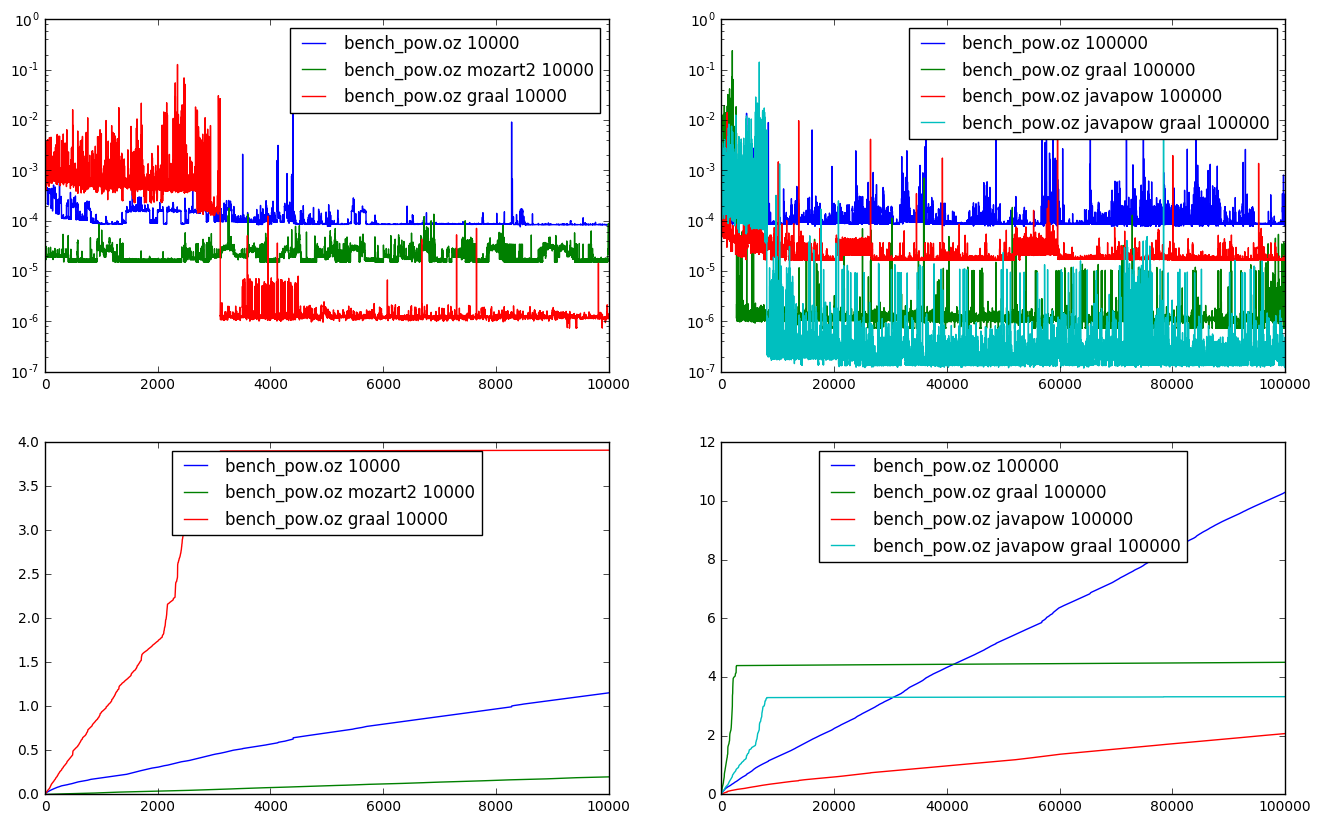

median [  8.69015000e-05   1.72680000e-05   1.28000000e-06]
median [  8.68900000e-05   1.13400000e-06   1.71520000e-05   1.73000000e-07]


In [8]:
medium()

pow_easy, pow_hard = Serie("pow")["10000", "100000"]

pow_easy.sub(221).plot()
pow_easy.sub(223).prog()

pow_hard.sub(222).plot()
pow_hard.sub(224).prog()
plt.show()

print("median", pow_easy.agg(np.median))
print("median", pow_hard.agg(np.median))

## Map

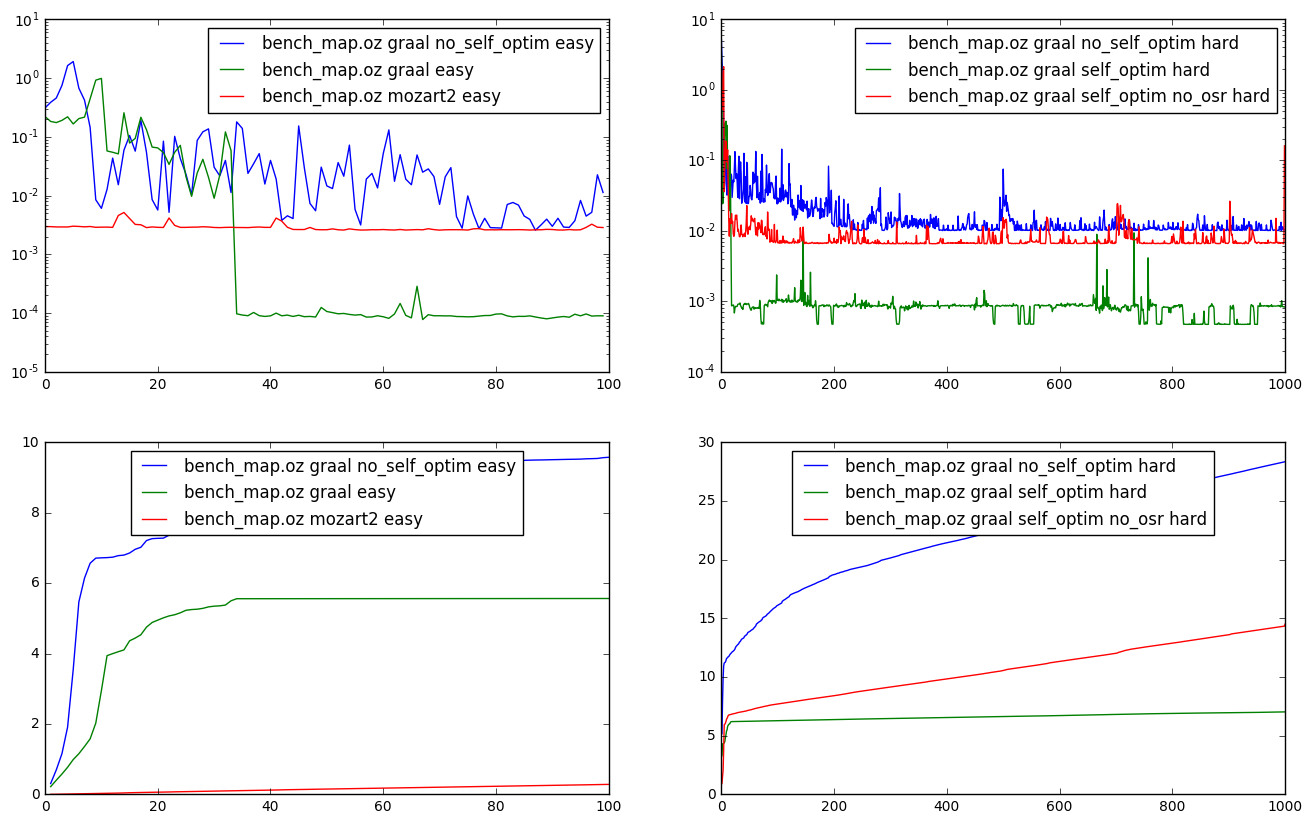

median [  1.90751920e-02   9.42510000e-05   2.73314650e-03]
median [ 0.01138592  0.00086036  0.0067233 ]


In [9]:
medium()

map_easy, map_hard = Serie("map")["easy", "hard"]

map_easy.sub(221).plot()
map_easy.sub(223).prog()

map_hard.sub(222).plot()
map_hard.sub(224).prog()
plt.show()

print("median", map_easy.agg(np.median))
print("median", map_hard.agg(np.median))

In [10]:
Serie("project")[""].mat

array([[ 18.0697297 ],
       [ 54.75731435]])

## Cost of measurements

Of course, in the previous graphs, it may have been possible the measure would be non-negligible in some results. Let's plot a no-op benchmark in order to see the order of magnitude

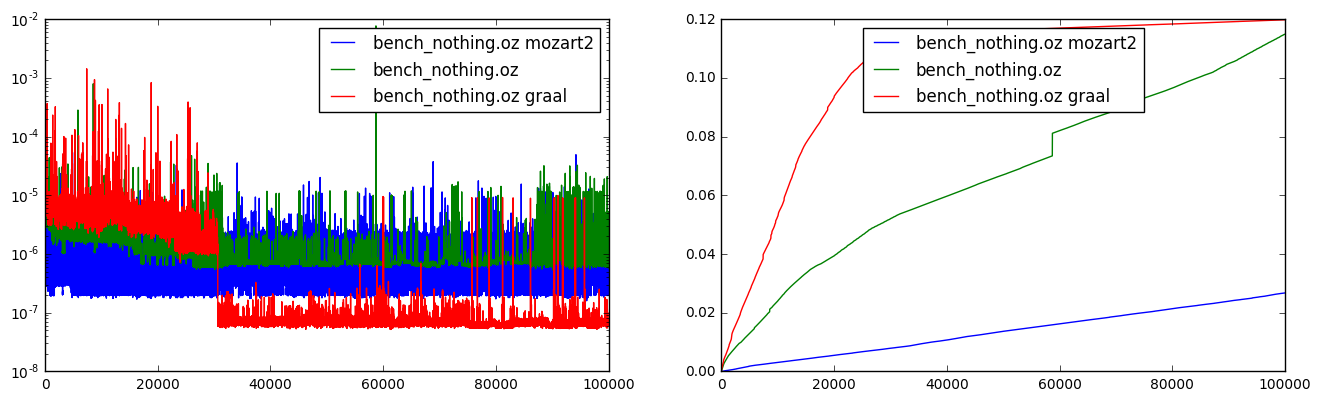

median [  2.16000000e-07   7.15000000e-07   7.20000000e-08]


In [11]:
medium()

nothing = Serie("nothing")["100000"]
nothing.sub(221).plot()
nothing.sub(222).prog()
plt.show()

print("median", nothing.agg(np.median))